# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 

1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook



In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашей функции должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.7 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.4 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)

In [204]:
#пример из листочка 1
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])

In [24]:
def _draw_get_intersections(A, b):
    A_ext = np.vstack((A, np.eye(2)))
    b_ext = np.hstack((b, np.zeros(2)))
    m = A_ext.shape[0]
    
    intersections = set([])
    # Попарно пересекаем все прямые.
    for i in range(m):
        for j in range(i + 1, m):
            # Проверяем, что векторы не параллельны.
            if A_ext[i][0] * A_ext[j][1] == A_ext[j][0] * A_ext[i][1]:
                continue
            point = np.linalg.solve(A_ext[[i, j], :], b_ext[[i, j]])
            if point[0] < 0 or point[1] < 0:
                continue
            if np.sum(A @ point > b) == 0:
                intersections.add((point[0], point[1]))
    return np.array(list(intersections))

In [118]:
def _draw(A, b, steps, points):
    m = A.shape[0]
    n = A.shape[1]
    
    # Точки пересечений прямых.
    intersections = _draw_get_intersections(A, b)
    # Вспомогательные точки, помогающие определить, сколько
    # надо прорисовать.
    points_x1 = intersections[:, 0][intersections[:, 1] == 0]
    points_x2 = intersections[:, 1][intersections[:, 0] == 0]
        
    fig, ax = plt.subplots(steps + 1)
    if steps == 0:
        ax = [ax]
    fig.set_figheight(5 * (steps + 1))
    fig.set_figwidth(5)
        
    xlim = np.max(intersections[:, 0])
    ylim = np.max(intersections[:, 1])
    lim = max(xlim, ylim)
        
    for i, a in enumerate(ax):
        a.plot(points_x1, points_x1 * 0, color='blue')
        a.plot(points_x2 * 0, points_x2, color='blue')

        for j in range(m):
            if A[j, 1] == 0:
                # Вертикальная прямая.
                a.plot([b[j], b[j]], [0, ylim], color='blue')
            elif A[j, 0] == 0:
                # Горизонтальная прямая.
                a.plot([0, xlim], [b[j], b[j]], color='blue')
            else:
                a.plot([0, b[j] / A[j, 0]], [b[j] / A[j, 1] , 0],
                           color='blue')
            
        a.set_xlabel('$x_1$', fontsize=15)
        a.set_ylabel('$x_2$', fontsize=15)
            
        a.set_xlim([-0.1 * lim, 1.1 * lim])
        a.set_ylim([-0.1 * lim, 1.1 * lim])
            
        a.scatter(intersections[:, 0], intersections[:, 1], color='black')
        a.scatter(points[i][0], points[i][1], color='red')
        a.set_title('Итерация %d: $x=(%.2f, %.2f)$' % (i + 1,
                        points[i][0], points[i][1]), fontsize=15)

    plt.tight_layout()
    plt.show()    

In [191]:
def _solve_lin_prog_simple(A, b, c, method='bland', start_point=None):
    """
    Симплекс-метод в простом случае;
    
    A - матрица;
    b - вектор ограничений типа <=; все элементы неотрицательны;
    с - функция полезности; задача максимизации.
    Считается, что все необходимые переменные в матрицы и векторы
    уже добавлены.
    
    method - 'blend', 'lexical'
    start_point - точка; в предположении, что переменные неотрицательны
    draw - true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор, на котором достигается максимум, максимальное значение,
    число итераций, посещенные точки.
    """
    # Счетчик шагов симплекс-метода.
    # Шагом считается один переход из точки в другую.
    steps = 0
    
    # Вектор, на котором достигается максимум и максимальное значение.
    res_vec = None
    res_opt = None
    
    # Устанавливаем число небазисных (n) и число базисных (m) переменных.
    m = A.shape[0]
    n = A.shape[1] - m

    B = None
    N = None
    
    if start_point is None:
        # Устанавливаем имена базисных (B) и небазисных (N) переменных
        # как [n, ..., n+m-1] и [0, 1, ..., n-1] соответственно.
        # Множества упорядочены, чтобы не терять соответствие со строками.
        B = n + np.arange(m)
        N = np.arange(n)
    else:
        # Если точка нулевая, то совпадает с методом выше.
        N = np.where(start_point == 0)[0][:n]
        B = np.array(list(set(range(n + m)) - set(list(N))))
    
    # Список координат точек, рассматриваемых алгоритмом.
    # Нужен для построения графика.
    points = []
    
    # Статус:
    # 0 --- не закончил работу;
    # 1 --- найдено оптимальное решение;
    # 2 --- задача не ограничена.
    status = 0
    while status == 0:
        A_B = A[:, B]
        A_N = A[:, N]
        
        c_B = c[B]
        c_N = c[N]
        
        A_B_inv = np.linalg.inv(A_B)
        pi = c_B.T @ A_B_inv
        c_cur = c_N.T - pi @ A_N
        b_cur = A_B_inv @ b
        
        point = np.zeros(n + m)
        point[B] = b_cur
        points.append(point)
        
        # Выбор входящей и покидающей переменной.
        # Индексация идет в упорядоченных наборах N и B соответственно.
        piv_col = None
        piv_row = None
        
        # Здесь можно понять, что решили задачу.
        possible_cols = N[c_cur > 0]
        if len(possible_cols) == 0:
            status = 1
            
            res_vec = np.zeros(n + m)
            res_vec[B] = b_cur 
            res_vec = res_vec
            
            res_opt = np.inner(c, res_vec)
            
            break
        
        # Выбирать входящую переменную в лексикографическом методе
        # можно любую среди имеющих неотрицательные коэффициенты,
        # поэтому будем делать по тому же принципу, что и в методе Бланда.
        piv_col = np.where(N == np.min(possible_cols))[0][0]
        y = (A_B_inv @ A_N)[:, piv_col]

        # Здесь можно понять, что задача не ограниченная.
        if np.sum(y > 0) == 0:
            status = 2
            res_opt = np.inf
            print(y)
            break
        
        if method == 'lexical':
            comp_rows = np.hstack((b_cur.reshape((m, 1)), A_N)) / y[:, np.newaxis]
            # Присваиваем бесконечные значения, чтобы в лексикографическом порядке
            # строки, соответствующие отсутствию ограничений,
            # шли позже тех, что с ограничениями. 
            comp_rows[y <= 0, 0] = np.inf
            piv_row = np.lexsort(np.rot90(comp_rows))[0]
        else:
            # Метод Бланда:
            increases = b_cur / y
            ambiguity = np.where(increases == np.min((increases)[y > 0]))[0]
            piv_row = np.where(B == np.min(B[ambiguity]))[0][0]
        
        # Переход к новому базису.
        entering = N[piv_col]
        leaving = B[piv_row]
        
        B[piv_row] = entering
        N[piv_col] = leaving
        
        steps += 1
        
    return res_vec, res_opt, steps, points

In [221]:
def solve_lin_prog (A, b, c, method='blend',
                    start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции,
    если это необходимо.
    
    A - матрица;
    b - вектор ограничений типа <=;
    с - функция полезности; задача максимизации.
    method - 'blend', 'lexical'
    start_point - точка
    draw - true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор, на котором достигается максимум, максимальное значение, число итераций
    """
    # Счетчик шагов симплекс-метода.
    # Шагом считается один переход из точки в другую.
    steps = 0
    
    # Вектор, на котором достигается максимум и максимальное значение.
    res_vec = None
    res_opt = None
    
    # Посещаемые точки:
    points = []
    
    # Модифицированные A, c, start_point чтобы решать через них
    # симплекс-метод в базовом случае.
    A_ext = None
    c_ext = None
    b_ext = None
    start_point_ext = None
    
    if start_point is not None:
        # Каждую переменную x разбиваем на x_+ - x_-,
        # где x_+, x_- неотрицательны.
        A_ext = np.hstack((A, -A))
        A_ext = np.vstack((A_ext,
                np.hstack((np.eye(A.shape[1]), -np.eye(A.shape[1])))))
        b_ext = np.hstack((b, np.zeros(A.shape[1])))
        c_ext = np.hstack((c, -c))
        start_point_ext = np.hstack((start_point, np.zeros(A.shape[1])))
    else:
        A_ext = A
        c_ext = c
        b_ext = b
    
    feasible = True
    
    # Первая фаза - недописпно
    if (b < 0).any():
        A_1 = A_ext
        A_1[np.where(b < 0)[0], :] *= -1
        A_1 = np.hstack((A_1, np.eye(len(b))))
        b_1 = np.abs(b)
        c_1 = np.hstack((np.zeros(len(b)), -np.ones(len(b))))
        res_vec_1, res_opt_1, steps, points_1 = _solve_lin_prog_simple(
            A, b, c, method=method, start_point=start_point_ext)
        
        if res_opt_1 < 0:
            feasible = False
        elif (res_vec_1[-len(b):] == 0).all():
            for point in points_1:
                points.append(point[:A_1.shape[1]])
            start_point_ext = res_vec[:A_1.shape[1]]
                
    if start_point is not None:
        start_point_ext = np.hstack((start_point_ext,
                        b_ext - A_ext @ start_point_ext))
   
    # Добавляем в матрицу A столбцы для новых переменных.
    A_ext = np.hstack((A_ext, np.eye(len(b_ext))))
    
    # Добавляем в целевую функцию коэффициенты для новых переменных.
    c_ext = np.hstack((c_ext, np.zeros(len(b_ext))))
    res_vec_ext, res_opt, steps_ext, points_ext = _solve_lin_prog_simple(
        A_ext, b_ext, c_ext, method=method, start_point=start_point_ext)
    
    # Возвращаемся к исходным переменным.
    steps += steps_ext
    for point in points_ext:
        if start_point is None:
            points.append(point[:A.shape[1]])
        else:
            points.append(point[:A.shape[1]] -
                         point[A.shape[1]:(2 * A.shape[1])])
    if res_vec_ext is not None:        
        if start_point is None:
            res_vec = res_vec_ext[:A.shape[1]]
        else:
            res_vec = point[:A.shape[1]] - point[A.shape[1]:(2 * A.shape[1])]

    if A.shape[0] == 2 and draw:
        _draw(A, b, steps, points)
    return res_vec, res_opt, steps

In [222]:
from itertools import combinations

def is_optimal (A, b, c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n, m за константное время
    """
    m = A.shape[0]
    n = A.shape[1]
    A_ext = np.hstack((A, np.eye(m)))
    
    opt_sols = []
    opt = -np.inf
    # Перебираем все возможные точки, рассматривая дополнительные
    # переменные, оставляя нули среди достаточного числа переменных.
    for p in combinations(range(m + n), m):
        point = np.zeros(m + n)
        if np.linalg.matrix_rank(A_ext[:, np.array(p)]) < m:
            continue
        point[np.array(p)] = np.linalg.solve(A_ext[:,
                                    np.array(p)], b)
        if (point < 0).any():
            continue
        new_opt = c @ point[:n]
        if new_opt == opt:
            opt_sols.append(tuple(point[:n]))
        elif new_opt > opt:
            opt_sols = [tuple(point[:n])]
            opt = new_opt
    
    res = False
    for sol in opt_sols:
        if tuple(sol) == tuple(x):
            res = True
            break
    return res

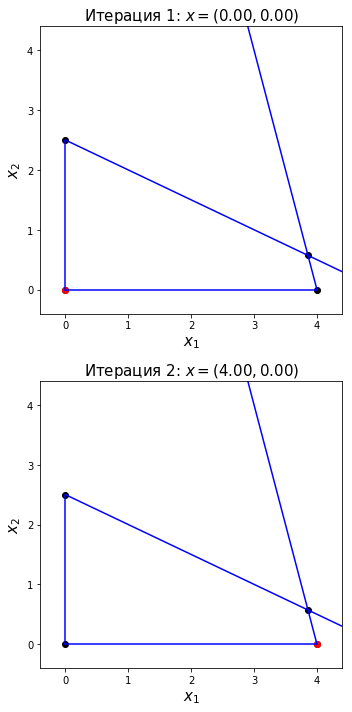

In [223]:
x, best, n_iter = solve_lin_prog(A,b,c, draw=True)

In [209]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

Точка:  [ 4.  0.]
Ответ:  20.0
Число итераций:  1


In [210]:
is_optimal(A,b,c,x)

True

## Бонус +1 Балл
Напишите программу которая для обоих методов из второй задачи пункта 5 (метод Бланда и лексикографический порядок) будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)

# ==========================================================
# Задача на МНК (0.4 балла)

In [1]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t, a): 
    return a[2] * sin(t) + a[1] * t + a[0]
    
"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m = 200
t = [i * 10.0 / m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a = [10, 100, 1000]

def get_y(a, σ):
    """Результаты измерений отличаются от истинных значений
    в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real = np.array([y(i, a) for i in t])
    y_corr = y_real + np.random.normal(0, σ, m)
    return y_real, y_corr

# todo -выбрать параметр
σ = 0.5

# Генерация значений: изначальные и с помехами.
y_real, y_corr = get_y(a, σ)


def get_params (y_corr, t, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    • method=0 -> сумма квадратов невязок будет минимальна.
    • method=1 -> сумма абсолютных значений невязок будет минимальна.
    • method=2 -> максимальное абсолютное значение невязки будет минимально.
    """
    A = np.vstack(np.sin(t), t, np.ones(len(t)))
    if method == 0:
        a = np.linalg.solve(A.T @ A, y_corr)
        return a
    elif method == 1:
        return [0,0,0]
    else:
        return [0,0,0]

## Задание 1 (0.2 балла)
1\.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2\.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?

3\.	Скорректируйте y_corr[0]  и y_corr[-1]: пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [ ]:
y_corr[0] += σ * 100
y_corr[-1] -= σ * 100

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

In [6]:
A = np.random.normal(size=(200, 80))
b = np.random.normal(size=200)

1\. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.

2\. Постройте распределение ошибок для каждого решения.

3\. Какими свойствами обладают распределения?